# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.4 MB 7.2 MB/s 
     |████████████████████████████████| 376 kB 70.4 MB/s 
     |████████████████████████████████| 235 kB 72.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3 MB 65.9 MB/s 
     |████████████████████████████████| 880 kB 59.7 MB/s 
     |████████████████████████████████| 182 kB 65.1 MB/s 
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292864 sha256=f72d30f2bfe83186db75fd3076ce2d4aae49d2a4f965e53b76f519695a25cc05
  Stored in directory: /root/.cache/pip/wheels/b3/c3/6e/3fca67aaef3657c2266e9ee439b54f534f05967cd8774cc65b
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0a118b21

In [ ]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image


def load_image(img,image_size, device):
     raw_image = img.convert('RGB')   

     w,h = raw_image.size
     display(raw_image.resize((w//5,h//5)))
    
     transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
     image = transform(raw_image).unsqueeze(0).to(device)   
     return image


In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# VQA
Perform visual question answering using finetuned BLIP model

# Image Captioning
Perform image captioning using finetuned BLIP model

In [ ]:
import os
import spacy
import random
nlp = spacy.load("en_core_web_sm")



def get_subjects(model, image):
  with torch.no_grad():
     

    question = 'what is the subject of this image?'

    ## use the model to retrieve the subject of the image

    answer = model(image, question, train=False, inference='generate') 
    answer_text = answer[0]
    
    #store subjects of noun text in a dictionary. The values will be the
    # descriptions we will use to form the caption

    noun_dict = {}

    doc = nlp(answer_text)

    subjects = doc.noun_chunks

    #package together the terms with an indicator of whether they are singular
    # or plural, so we can phrase the question correctly
    human_terms = [("man", "singular"), ("men", "plural"), ("woman", "singular"), 
                    ("women", "plural"), ("boys", "plural"), ("girls", "plural"), 
                   ("boy", "singular"), ("girl", "singular"), ("children", "plural"), 
                   ("child", "singular"), ("baby", "singular")]

    
    # use a decision tree to classify the human subjects

    for chunk in subjects:

      noun = str(chunk)

      for term in human_terms:
        if term[0] in noun:
          if term[1] == "singular":
            new_question = "What is the " + term[0] + " wearing?"
          elif term[1] == "plural":
            new_question = "What are the " + term[0] + " wearing?"
          
          new_caption = model(image, new_question, train=False, inference='generate')
        
          noun_dict[noun] = ("person", new_caption[0])
          break

        else:
          new_question = "Is the " + noun + " a person?"
          new_answer =  model(image, new_question, train=False, inference='generate')
          if new_answer[0].lower() == "yes":
            new_question = "What is the " + noun + " wearing?"
            new_caption = model(image, new_question, train=False, inference='generate')
            noun_dict[noun] = ("person", new_caption[0])
          else:
            new_question = "What color is the " + noun + "?"
            new_caption = model(image, new_question, train=False, inference='generate')
            noun_dict[noun] = ("other", new_caption[0])
    
    return noun_dict

def form_descriptions(noun_dict):
  our_caption = ""
  subjects = list(noun_dict.keys())
  len_generator = len(subjects)

  def form_one_description(noun: str):

      '''takes noun string and uses the noun_dict to turn it into an'''
      '''extended description'''

      if noun_dict[noun][0] == "other":
        description = "a " + noun_dict[noun][1] + " " + noun
      elif noun_dict[noun][0] == "person":
        description = "a " + noun + " in a " + noun_dict[noun][1]
      return description


  if len_generator == 1:
      our_caption += form_one_description(str(subjects[0]))
  elif len_generator == 2:
      our_caption += form_one_description(str(subjects[0]))
      our_caption += " and "
      our_caption += form_one_description(str(subjects[1]))
  elif len_generator > 2:
      our_caption += form_one_description(str(subjects[2]))

      for i in range(1, len_generator - 1):
        our_caption += ", a "
        our_caption += str(subjects[i])

      our_caption += "and a "
      our_caption += str(next(subjects))
  
  return our_caption


def add_caption(image):
  

  # setting up BLIP model

  from models.blip_vqa import blip_vqa

  image_size = 480  
  image = load_image(image, image_size=image_size, device=device)     

  model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
    
  model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
  model.eval()
  model = model.to(device)

  
  with torch.no_grad():
    #initialize capn string
    
    noun_dict = get_subjects(model, image)

    # look at the number of nouns in the list to see how to structure the 
    # sentence

    our_caption = form_descriptions(noun_dict)

      



    
    background_question = "Where is the picture set?"
    background = model(image, background_question, train=False, inference='generate')[0] 
    background = background.split(" ")
    if (len(background) >= 2):
      our_caption += ". The picture is set " + background[0] + " the " + background[1] + "."
    else:
      our_caption += ". The picture is set at the " + background[0]

  return('answer: '+ our_caption)

img_dir = '/content/BLIP/si_sample_imgs/New folder'
images = os.listdir(img_dir)

captions_list = []

for img in images:
  current_image = Image.open(img_dir + '/' + img)
  caption = add_caption(current_image)
  captions_list.append( (img, caption))
  # need a list of file locations



/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


FileNotFoundError: ignored

In [ ]:
prompts = []
prompts.append("Is the main subject of this image a work of art?")
prompts.append("Is there a large amount of text in this image?")
prompts.append("Is this a black and white image?")
prompts.append("Is the main subject of this image a person?")
prompts.append("Is the main subject of this image a non-human animal?")
prompts.append("Is the main subject of this image a piece of machinery?")
prompts.append("Is the main subject of this image a plant or plants?")
prompts.append("Is the main subject of this image an inanimate object?")

In [ ]:
!unzip /content/sample_project_imgs.zip

Archive:  /content/sample_project_imgs.zip
  inflating: sample_project_imgs/3_1128301182198394880.png  
  inflating: sample_project_imgs/3_1130496446145413120.png  
  inflating: sample_project_imgs/3_1138161291736911872.png  
  inflating: sample_project_imgs/3_1144757578519367680.png  
  inflating: sample_project_imgs/3_1146798784350806016.png  
  inflating: sample_project_imgs/3_1152271113831010307.png  
  inflating: sample_project_imgs/3_1158433753993228289.png  
  inflating: sample_project_imgs/3_1159822813605351430.png  
  inflating: sample_project_imgs/3_1177575728646197248.png  
  inflating: sample_project_imgs/3_1180121949533401088.png  
  inflating: sample_project_imgs/3_1189922483224363009.png  
  inflating: sample_project_imgs/3_1189931252847202304.png  
  inflating: sample_project_imgs/3_1194997186582532097.png  
  inflating: sample_project_imgs/3_1195329373265702913.png  
  inflating: sample_project_imgs/3_1204076718157266944.png  
  inflating: sample_project_imgs/3_1204077

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

  0%|          | 0.00/1.35G [00:00<?, ?B/s]

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


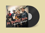

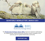

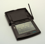

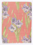

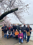

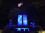

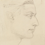

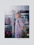

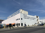

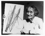

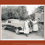

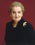

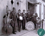

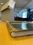

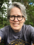

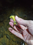

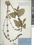

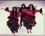

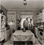

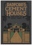

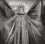

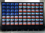

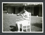

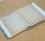

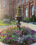

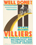

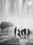

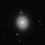

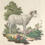

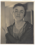

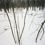

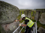

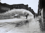

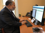

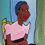

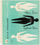

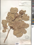

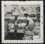

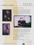

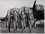

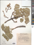

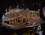

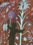

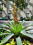

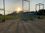

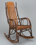

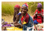

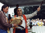

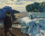

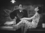

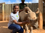

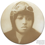

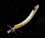

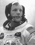

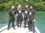

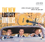

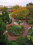

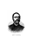

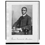

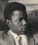

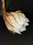

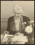

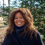

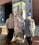

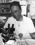

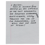

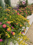

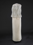

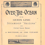

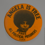

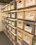

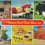

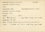

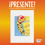

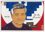

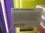

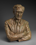

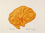

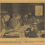

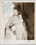

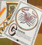

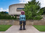

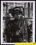

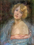

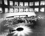

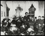

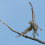

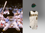

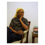

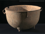

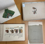

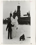

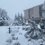

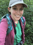

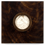

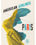

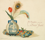

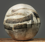

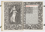

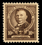

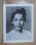

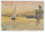

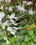

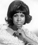

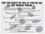

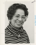

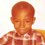

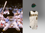

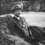

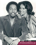

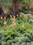

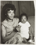

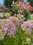

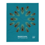

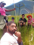

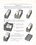

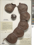

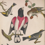

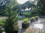

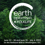

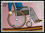

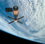

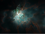

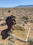

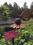

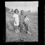

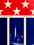

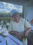

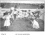

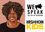

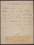

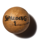

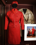

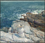

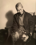

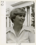

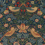

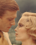

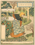

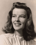

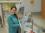

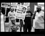

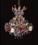

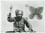

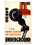

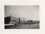

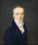

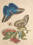

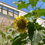

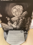

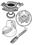

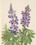

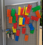

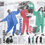

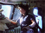

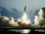

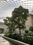

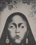

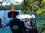

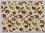

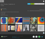

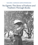

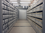

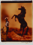

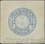

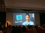

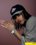

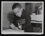

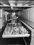

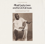

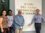

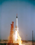

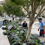

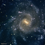

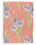

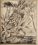

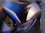

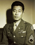

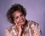

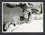

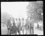

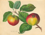

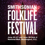

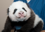

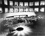

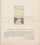

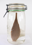

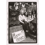

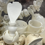

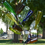

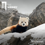

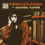

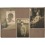

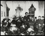

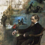

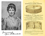

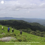

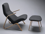

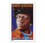

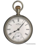

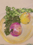

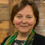

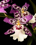

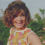

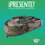

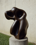

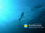

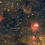

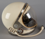

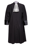

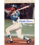

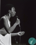

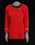

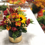

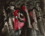

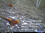

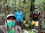

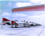

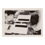

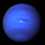

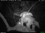

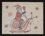

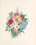

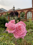

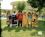

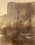

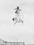

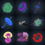

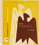

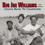

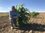

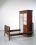

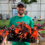

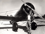

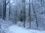

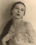

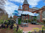

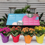

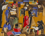

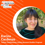

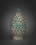

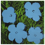

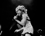

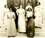

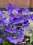

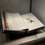

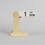

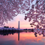

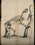

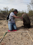

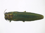

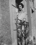

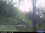

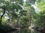

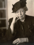

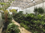

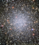

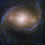

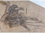

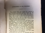

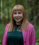

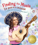

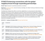

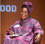

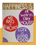

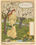

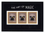

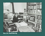

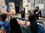

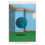

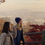

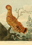

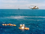

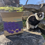

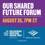

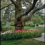

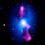

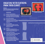

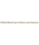

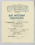

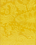

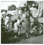

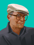

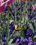

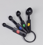

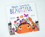

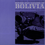

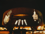

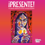

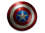

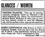

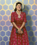

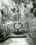

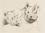

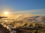

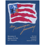

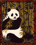

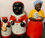

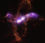

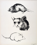

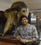

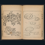

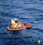

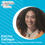

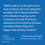

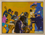

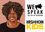

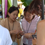

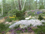

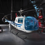

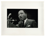

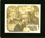

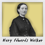

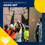

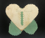

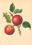

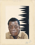

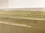

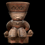

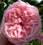

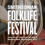

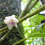

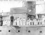

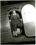

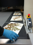

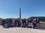

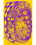

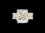

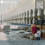

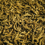

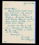

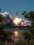

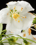

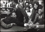

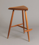

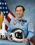

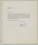

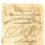

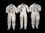

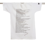

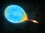

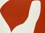

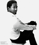

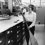

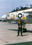

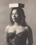

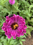

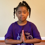

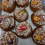

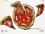

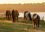

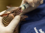

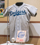

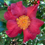

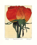

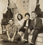

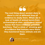

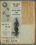

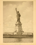

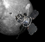

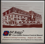

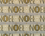

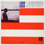

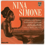

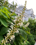

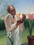

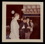

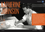

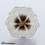

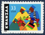

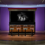

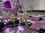

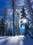

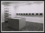

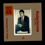

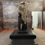

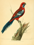

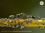

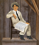

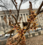

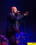

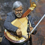

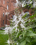

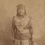

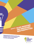

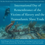

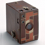

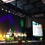

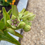

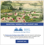

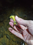

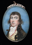

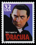

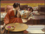

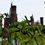

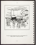

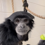

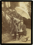

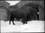

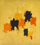

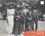

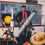

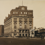

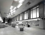

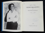

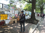

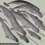

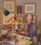

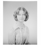

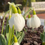

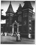

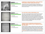

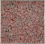

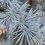

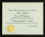

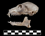

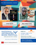

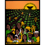

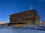

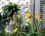

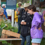

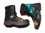

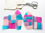

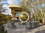

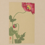

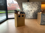

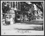

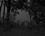

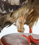

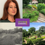

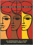

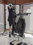

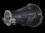

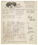

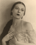

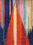

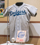

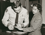

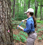

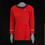

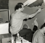

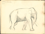

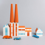

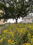

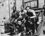

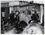

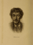

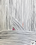

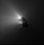

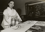

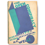

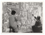

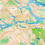

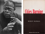

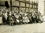

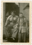

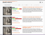

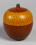

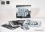

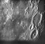

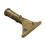

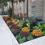

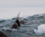

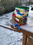

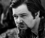

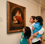

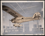

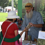

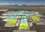

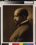

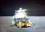

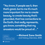

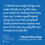

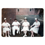

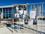

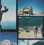

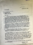

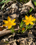

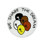

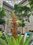

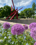

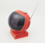

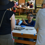

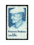

In [ ]:
## let's make a pandas dataframe consisting of metadata about each image. 
## we'll store the answers to each prompt and the compression ratio of the image.
import os
from PIL import Image
import pandas as pd

from models.blip_vqa import blip_vqa

image_size = 480  
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
    
model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

img_files = os.listdir("/content/BLIP/sample_project_imgs/")

row_list = []

dir = "/content/BLIP/sample_project_imgs/"

for file in img_files:
  row_dict = {}
  row_dict['filename'] = file
  row_dict['file_size'] = os.path.getsize(dir + file)
  im = Image.open(dir + file)
  width, height = im.size
  row_dict['pixels'] = width * height

  with torch.no_grad():
     
    image = load_image(im, image_size=image_size, device=device)     

    ## use the model to retrieve the subject of the image
    for i in range(len(prompts)):
      answer = model(image, prompts[i], train=False, inference='generate') 
      answer_text = answer[0]
      row_dict["prompt_" + str(i)] = answer_text

  row_list.append(row_dict)

img_df = pd.DataFrame.from_records(row_list)
img_df.to_csv('metadata.csv')





In [ ]:
from models.blip import blip_decoder

image_size = 384
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

dir = "/content/BLIP/sample_project_imgs/"
caption_list = []

with torch.no_grad():

    for file in img_files:
    # beam search
      row_dict = {}
      row_dict['filename'] = file

      im = Image.open(dir + file)
      image = load_image(im, image_size=image_size, device=device)   

      caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
      row_dict['caption'] = caption[0]
      caption_list.append(row_dict)
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 

caption_df = pd.DataFrame.from_records(caption_list)


# Feature Extraction

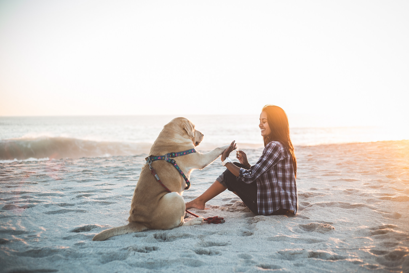

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth


In [ ]:
from models.blip import blip_feature_extractor

image_size = 224
image = load_demo_image(image_size=image_size, device=device)     

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'
    
model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

# Image-Text Matching

In [ ]:
from models.blip_itm import blip_itm

image_size = 384

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
    
model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device='cpu')

probabilities = []

for index, row in caption_df.iterrows():
  with Image.open(dir + row['filename']) as curr_img:
    image = load_image(curr_img, image_size=image_size, device='cpu')
    caption = row['caption']
    itm_output = model(image,caption,match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
    probabilities.append(itm_score)

caption_df['score'] = probabilities
print(caption_df.head())

ModuleNotFoundError: ignored